#Document Clustering with Python

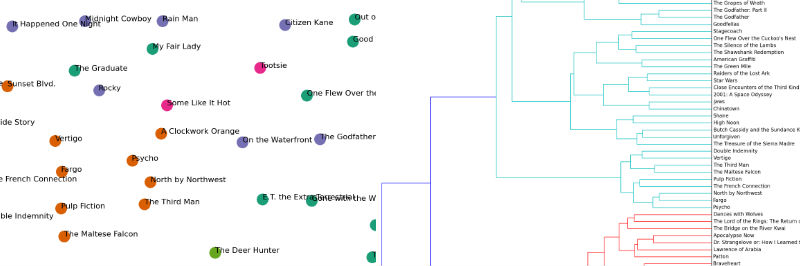

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopsis of the top 100 films of all time (per an IMDB list).

##Contents

<ul>
<li>Stopwords, stemming, and tokenization
<li>Tf-idf and document similarity
<li>K-means clustering
<li>Multidimensional scaling
<li>Visualizing document clusters
</ul>

But first, I import everything I am going to need up front

In [8]:
!pip install mpld3
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

     |████████████████████████████████| 890kB 5.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.2-cp36-none-any.whl size=200618 sha256=223de5b76b0d70bc90ccb15fb371e2c47628f463e6a1ffaf5d2d79d351ad4a1c
  Stored in directory: /root/.cache/pip/wheels/21/73/06/ea4b85609301850b1289a282852d92e22fcbf7a250ed5f547f
Successfully built mpld3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/MyDrive/MSDS-20/After Mid content/IR/Lecture 10/Uploads'


/content/drive/MyDrive/MSDS-20/After Mid content/IR/Lecture 10/Uploads


In [6]:
ls

genres_list.txt     synopsis_list_imdb.txt  title_list.txt
link_list_imdb.txt  synopsis_list_wiki.txt  Tutorial_4.ipynb


#Stopwords, stemming, and tokenizing

In [25]:
#import three lists: titles, links and wikipedia synopsis
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopsis_wiki = open('synopsis_list_wiki.txt').read().split('\n BREAKS HERE')
synopsis_wiki = synopsis_wiki[:100]
synopsis_clean_wiki = []
for text in synopsis_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopsis_clean_wiki.append(text)

synopsis_wiki = synopsis_clean_wiki
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopsis_wiki)) + ' synopsis')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopsis
100 genres


In [26]:
synopsis_imdb = open('synopsis_list_imdb.txt').read().split('\n BREAKS HERE')
synopsis_imdb = synopsis_imdb[:100]

synopsis_clean_imdb = []

for text in synopsis_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopsis_clean_imdb.append(text)

synopsis_imdb = synopsis_clean_imdb

In [35]:
synopsis = []

for i in range(len(synopsis_wiki)):
    item = synopsis_wiki[i] + synopsis_imdb[i]
    synopsis.append(item)
synopsis[:5]

[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

In [37]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []
print(titles)
for i in range(0,len(titles)):
    ranks.append(i)
ranks

['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca', "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'Citizen Kane', 'The Wizard of Oz', 'Titanic', 'Lawrence of Arabia', 'The Godfather: Part II', 'Psycho', 'Sunset Blvd.', 'Vertigo', 'On the Waterfront', 'Forrest Gump', 'The Sound of Music', 'West Side Story', 'Star Wars', 'E.T. the Extra-Terrestrial', '2001: A Space Odyssey', 'The Silence of the Lambs', 'Chinatown', 'The Bridge on the River Kwai', "Singin' in the Rain", "It's a Wonderful Life", 'Some Like It Hot', '12 Angry Men', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 'Amadeus', 'Apocalypse Now', 'Gandhi', 'The Lord of the Rings: The Return of the King', 'Gladiator', 'From Here to Eternity', 'Saving Private Ryan', 'Unforgiven', 'Raiders of the Lost Ark', 'Rocky', 'A Streetcar Named Desire', 'The Philadelphia Story', 'To Kill a Mockingbird', 'An American in Paris', 'The Best Years of Our Lives', 'My Fair

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

This section is focused on defining some functions to manipulate the synopsis. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [41]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>



In [42]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

##Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopsis* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopsis)
<li> min_df: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopsis use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams] (http://en.wikipedia.org/wiki/N-gram)
</ul>

In [39]:
nltk.download('stopwords')
nltk.download('punkt')  # punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(synopsis)

print(tfidf_matrix.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(100, 563)


In [49]:
terms = tfidf_vectorizer.get_feature_names()
terms

["'d",
 "'s death",
 "'s father",
 "'s friend",
 "'s hous",
 "'s mother",
 'abandon',
 'abl',
 'accept',
 'accid',
 'accompani',
 'accus',
 'act',
 'action',
 'actual',
 'admit',
 'afterward',
 'ago',
 'agre',
 'air',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'american',
 'angri',
 'angrili',
 'ani',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'ask',
 'assign',
 'assist',
 'assum',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attract',
 'audienc',
 'avoid',
 'away',
 'bad',
 'bar',
 'bare',
 'battl',
 'beat',
 'becaus',
 'becom',
 'bed',
 'beg',
 'believ',
 'best',
 'better',
 'big',
 'black',
 'blow',
 'board',
 'bodi',
 'book',
 'boss',
 'boy',
 'break',
 'brief',
 'bring',
 'broken',
 'brother',
 'build',
 'burn',
 'busi',
 'buy',
 'ca',
 "ca n't",
 'camp',
 'captain',
 'captur',
 'car',
 'care',
 'career',
 'carri',
 'case',
 'catch',
 'caus',
 'chanc'

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [51]:
tfidf_mat = tfidf_matrix.toarray()

In [52]:
print(tfidf_matrix)

  (0, 4)	0.015840237403117192
  (0, 548)	0.01612420215693917
  (0, 87)	0.013158145917863982
  (0, 168)	0.01127492073118682
  (0, 208)	0.047520712209351584
  (0, 554)	0.015840237403117192
  (0, 427)	0.08485730621728925
  (0, 1)	0.046705079955494354
  (0, 343)	0.06022813901532093
  (0, 108)	0.012147386431826087
  (0, 287)	0.015840237403117192
  (0, 299)	0.013534028158239696
  (0, 306)	0.009010032167901243
  (0, 417)	0.015307582752631105
  (0, 37)	0.01184313106771756
  (0, 15)	0.01334332279941062
  (0, 222)	0.010753148800711149
  (0, 446)	0.013158145917863982
  (0, 437)	0.008289477056589938
  (0, 24)	0.013730602286522562
  (0, 497)	0.016421379232122783
  (0, 82)	0.012305126670905985
  (0, 483)	0.02916724306696112
  (0, 169)	0.0252655923822052
  (0, 200)	0.015568359985164785
  :	:
  (99, 383)	0.08619640541457027
  (99, 358)	0.07672891325500265
  (99, 177)	0.20333482818614418
  (99, 368)	0.09393190975382117
  (99, 215)	0.13192312316278199
  (99, 438)	0.06821489514982466
  (99, 283)	0.335609

In [53]:
print(dist)

[[ 0.00000000e+00  8.00539634e-01  7.62813109e-01 ...  6.41312416e-01
   6.70578229e-01  8.23926244e-01]
 [ 8.00539634e-01 -2.22044605e-16  7.33477850e-01 ...  7.33117814e-01
   7.71609239e-01  8.92974798e-01]
 [ 7.62813109e-01  7.33477850e-01  0.00000000e+00 ...  7.23806699e-01
   7.49489708e-01  8.58673233e-01]
 ...
 [ 6.41312416e-01  7.33117814e-01  7.23806699e-01 ...  0.00000000e+00
   4.50879024e-01  9.17464687e-01]
 [ 6.70578229e-01  7.71609239e-01  7.49489708e-01 ...  4.50879024e-01
   2.22044605e-16  8.68599864e-01]
 [ 8.23926244e-01  8.92974798e-01  8.58673233e-01 ...  9.17464687e-01
   8.68599864e-01 -2.22044605e-16]]


#K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopsis. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

In [54]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters = num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')

clusters = km.labels_.tolist()

In [ ]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopsis, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [ ]:
frame

,rank,title,cluster,genre
1,0,The Godfather,1,"[u' Crime', u' Drama']"
1,1,The Shawshank Redemption,1,"[u' Crime', u' Drama']"
1,2,Schindler's List,1,"[u' Biography', u' Drama', u' History']"
2,3,Raging Bull,2,"[u' Biography', u' Drama', u' Sport']"
1,4,Casablanca,1,"[u' Drama', u' Romance', u' War']"
...,...,...,...,...
2,95,Rebel Without a Cause,2,[u' Drama']
2,96,Rear Window,2,"[u' Mystery', u' Thriller']"
2,97,The Third Man,2,"[u' Film-Noir', u' Mystery', u' Thriller']"
2,98,North by Northwest,2,"[u' Mystery', u' Thriller']"


In [ ]:
frame['cluster'].value_counts()

2    40
0    25
1    21
3    10
4     4
Name: cluster, dtype: int64

In [ ]:
grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    45.400000
1    36.952381
2    57.150000
3    55.400000
4    49.750000
Name: rank, dtype: float64

#Multidimensional scaling

In [ ]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
pos

array([[ 0.18427284, -0.01171561],
       [ 0.44206412, -0.27869805],
       [-0.03159215, -0.45663791],
       [-0.13227196,  0.57453848],
       [-0.25873684, -0.26527517],
       [ 0.05822957,  0.25692953],
       [ 0.05839902, -0.04612822],
       [ 0.01170734,  0.46244858],
       [-0.43458221, -0.29655933],
       [ 0.60374328, -0.34569913],
       [-0.25090779, -0.57483017],
       [ 0.0716498 ,  0.13140843],
       [-0.22775176,  0.06867225],
       [-0.43012185,  0.28528616],
       [-0.35275605,  0.12706104],
       [-0.05321665,  0.12337032],
       [ 0.35480636,  0.00823039],
       [ 0.5523204 ,  0.49066955],
       [-0.48429635,  0.17299124],
       [ 0.19843842, -0.38929168],
       [-0.0217225 , -0.04277899],
       [ 0.35008658, -0.33952163],
       [ 0.51778119, -0.25366187],
       [-0.55230241, -0.22470452],
       [-0.08222117, -0.57833712],
       [-0.34166784,  0.63444443],
       [ 0.41840442,  0.58504899],
       [-0.17157923,  0.23225249],
       [ 0.53075088,

##Visualizing document clusters

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

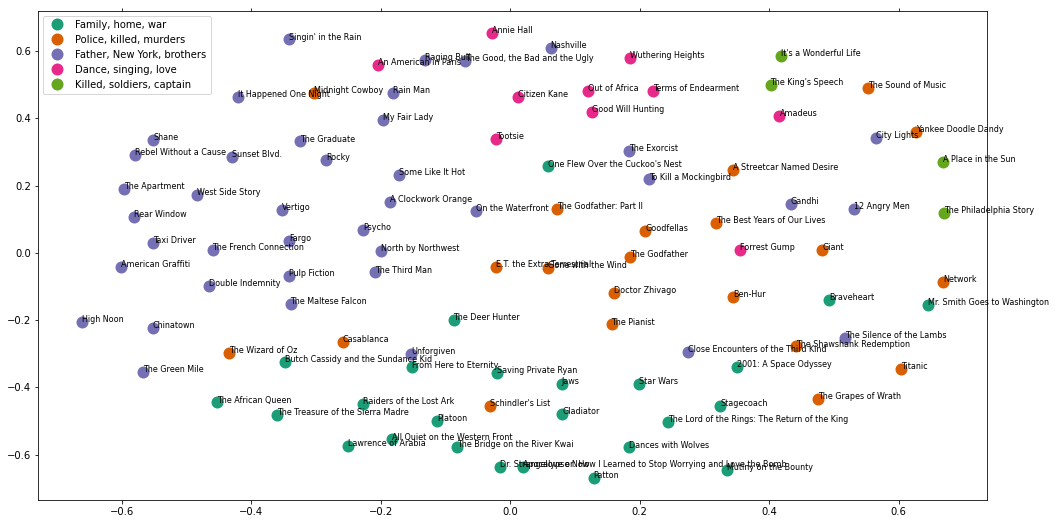

In [ ]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot
plt.close()
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

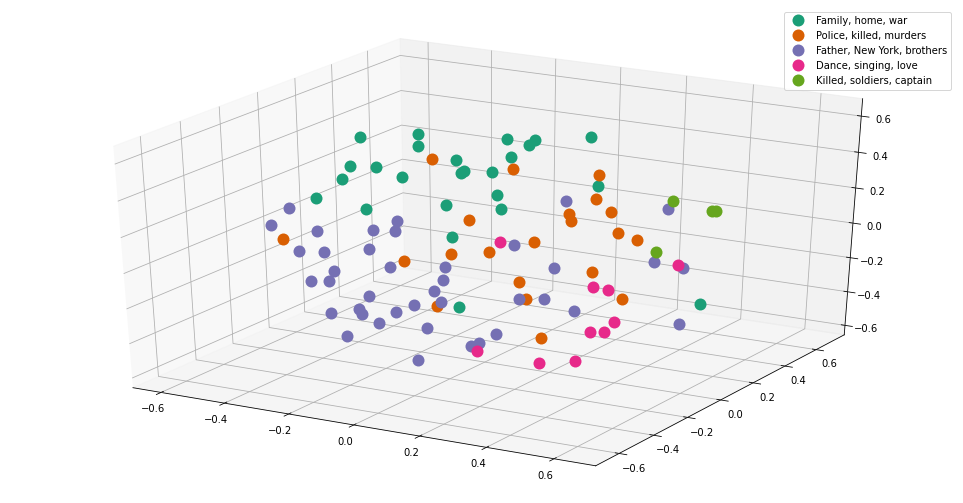

In [ ]:
MDS()
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)

df = pd.DataFrame(dict(x=pos[:,0], y=pos[:,1], z=pos[:,2], label=clusters, title=titles)) 
groups = df.groupby('label')

# set up plot
fig = plt.figure(figsize=(17, 9))
ax = fig.add_subplot(111, projection='3d')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point   

# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['z'], df.loc[i]['title'], size=8)  

plt.show() #show the plot
plt.close()
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

No handles with labels found to put in legend.


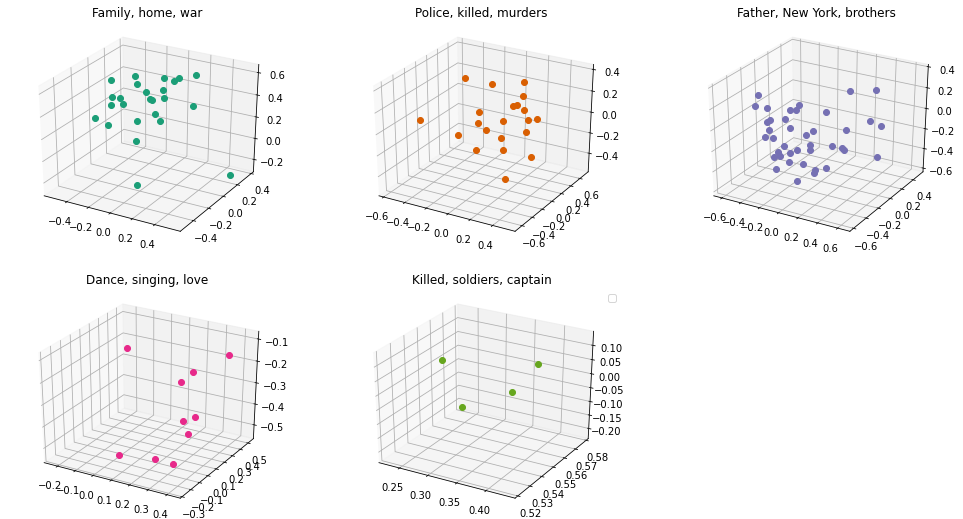

In [ ]:
df = pd.DataFrame(dict(x=pos[:,0], y=pos[:,1], z=pos[:,2], label=clusters, title=titles)) 
groups = df.groupby('label')

# set up plot
fig = plt.figure(figsize=(17, 9))

i = 1
for name, group in groups:
    ax = fig.add_subplot(230+i, projection='3d')
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=6, color=cluster_colors[name])
    ax.title.set_text(cluster_names[name])
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    i+=1
ax.legend(numpoints=1)  #show legend with only 1 point   
    
plt.show() #show the plot
plt.close()
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# **Cluster Analysis**

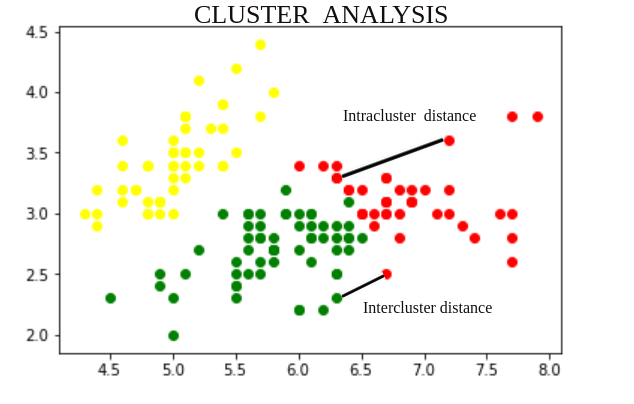

## **Internal Evaluation**

### Intercluster Distance
Intercluster distance is the distance between two objects belonging to two different clusters. It is of 5 types.

NOTE:
In the following expressions: S and T are two seperate clusters & x and y are the data points belonging to these clusters respectively.
In the coding examples, I used cluster 2 ('Father, New York, brothers') and cluster 4 ('Killed, soldiers, captain').

In [ ]:
temp = pd.DataFrame(tfidf_mat)
terms_idx = [str(i) for i in range(len(temp.columns))]
temp.columns = terms_idx
temp['cluster'] = clusters

c2 = temp[temp.cluster==2].loc[:, '0':'562'].values
center_c2 = np.sum(c2, axis=0) / len(c2)
center_c2 = center_c2.reshape(1,-1)

c4 = temp[temp.cluster==4].loc[:, '0':'562'].values
center_c4 = np.sum(c4, axis=0) / len(c4)
center_c4 = center_c4.reshape(1,-1)

In [ ]:
from numpy import dot
from numpy.linalg import norm

In [ ]:
def distance(cluster1, cluster2, check = False):
    out = list()
    for i in range(len(cluster1)):
        for j in range(len(cluster2)):
            if check:
                if (i != j):
                    cos_sim = dot(cluster1[i,:], cluster2[j,:]) / (norm(cluster1[i,:])*norm(cluster2[j,:]))
                    out.append(1 - cos_sim)
            else:
                cos_sim = dot(cluster1[i,:], cluster2[j,:]) / (norm(cluster1[i,:])*norm(cluster2[j,:]))
                out.append(1 - cos_sim)
    return np.array(out)

>**Single Linkage Distance:** The single linkage distance is the closest distance between two objects belonging to two different clusters defined as

>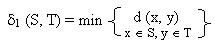




In [ ]:
sld = np.min(distance(c2, c4))
sld

0.7150556514354711

>**Complete Linkage Distance:** The complete linkage distance is the distance between two most remote objects belonging to two different clusters defined as

>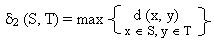

In [ ]:
cld = np.max(distance(c2, c4))
cld

0.9514738874668963

>**Average Linkage Distance:** The average linkage distance is the average distance between all the objects belonging to two different clusters defined as

>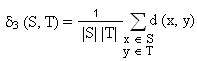

In [ ]:
ald = np.sum(distance(c2, c4))/(len(c2)*len(c4))
ald

0.8656867888494986

>**Centroid Linkage Distance:** The centroid linkage distance is the distance between the centers vs and vt of two clusters S and T respectively, defined as

>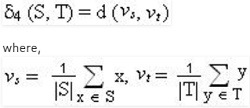

In [ ]:
centld = distance(center_c2, center_c4)[0]
centld

0.6882205222058173

>**Average Centroid Linkage Distance:** The average centroid linkage distance is the distance between the center of a cluster and all the objects belonging to a different cluster, defined as

>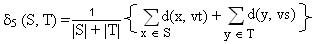

In [ ]:
acentld = ( np.sum(distance(c2, center_c4)) + np.sum(distance(c4, center_c2)) ) / ( len(c2)+len(c4) )
acentld

0.8283437941602245

### Intracuster Distance:

Intracluster distance is the distance between two objects belonging to same cluster. It is of 3 types.

>**Complete Diameter Distance:** The complete diameter distance is the distance between two most remote objects belonging to the same cluster defined as

>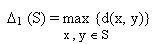

In [ ]:
cdd = np.max(distance(c2,c2))
cdd

0.947324564527731

>**Average Diameter Distance:** The average diameter distance is the average distance between all the objects belonging to the same cluster defined as

>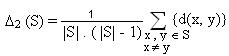

In [ ]:
add = np.sum(distance(c2,c2, True)) / ( len(c2)*(len(c2)-1) )
add

0.7447722491529267

>**Centroid Diameter Distance:** The centroid diameter distance is double average distance between all of the objects and the cluster center of s defined as

>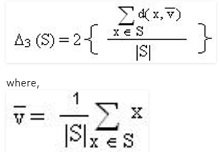

In [ ]:
centdd = 2 * ( np.sum(distance(c2,center_c2)) / len(c2) )
centdd

0.953392036957684

#### **Note**:
>If a clustering algorithm makes clusters so that the Intercluster distance between different clusters is more and Intracluster distance of same cluster is less, then we can tell that it is a good clustering algorithm.

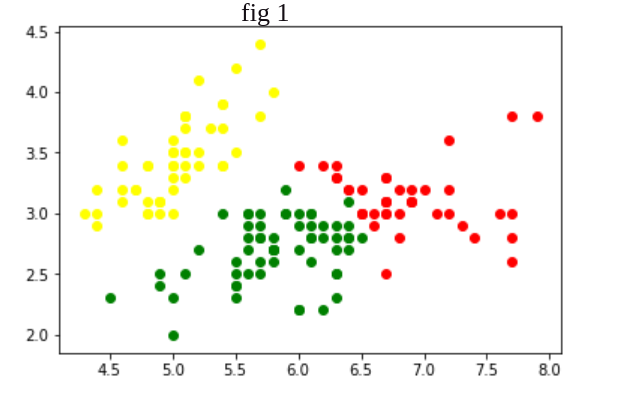

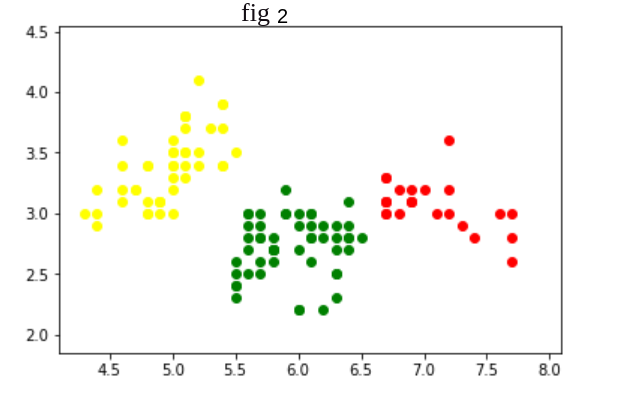

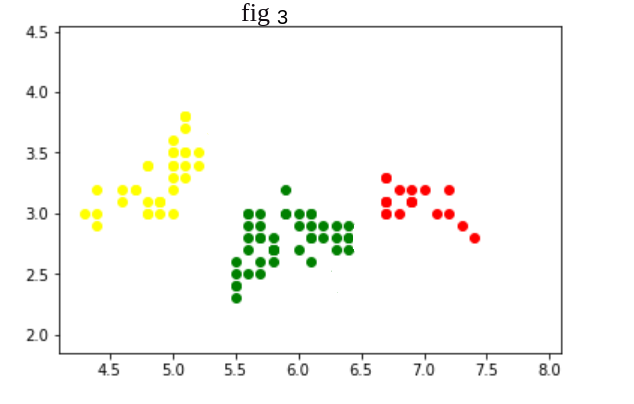

Here clustering algorithm in fig 3 is better than fig 2 and fig 1 as in fig 3 Intercluster distance is more and Intracluster distance is less.

## **External Evaluation**

### Purity

The ratio between the dominant class in a cluster and the size of cluster.

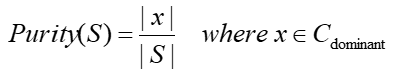

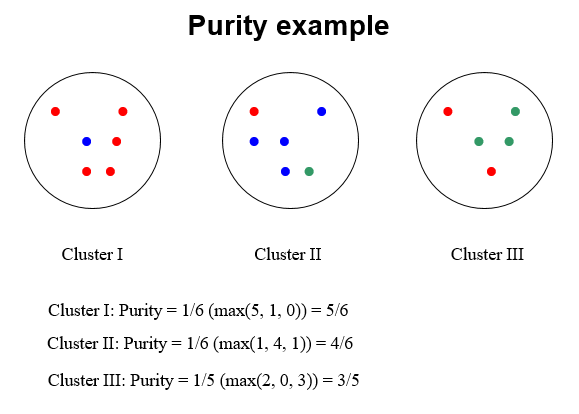

In [ ]:
classes = { 0:["Schindler's List", "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'The Wizard of Oz', 'Titanic', 'Forrest Gump', 'E.T. the Extra-Terrestrial', 'The Silence of the Lambs', 'Gandhi', 'A Streetcar Named Desire', 'The Best Years of Our Lives', 'My Fair Lady', 'Ben-Hur', 'Doctor Zhivago', 'The Pianist', 'The Exorcist', 'Out of Africa', 'Good Will Hunting', 'Terms of Endearment', 'Giant', 'The Grapes of Wrath', 'Close Encounters of the Third Kind', 'The Graduate', 'Stagecoach', 'Wuthering Heights'], \
            1:['Casablanca', 'Psycho', 'Sunset Blvd.', 'Vertigo', 'Chinatown', 'Amadeus', 'High Noon', 'The French Connection', 'Fargo', 'Pulp Fiction', 'The Maltese Falcon', 'A Clockwork Orange', 'Double Indemnity', 'Rebel Without a Cause', 'The Third Man', 'North by Northwest'],
            2:['The Godfather', 'Raging Bull', 'Citizen Kane', 'The Godfather: Part II', 'On the Waterfront', '12 Angry Men', '40	Rocky', 'To Kill a Mockingbird', 'Braveheart', 'The Good, the Bad and the Ugly', 'The Apartment', 'Goodfellas', 'City Lights', 'It Happened One Night', 'Midnight Cowboy', 'Mr. Smith Goes to Washington', 'Rain Man', 'Annie Hall', 'Network', 'Taxi Driver', 'Rear Window'],
            3:['West Side Story', "Singin' in the Rain", "It's a Wonderful Life", 'Some Like It Hot', 'The Philadelphia Story', 'An American in Paris', "The King's Speech", 'A Place in the Sun', 'Tootsie', 'Nashville', 'American Graffiti', 'Yankee Doodle Dandy'],
            4:['The Shawshank Redemption', 'Lawrence of Arabia', 'The Sound of Music', 'Star Wars', '2001: A Space Odyssey', 'The Bridge on the River Kwai', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb', 'Apocalypse Now', 'The Lord of the Rings: The Return of the King', 'Gladiator', 'From Here to Eternity', 'Saving Private Ryan', 'Unforgiven', 'Raiders of the Lost Ark', 'Patton', 'Jaws', 'Butch Cassidy and the Sundance Kid', 'The Treasure of the Sierra Madre', 'Platoon', 'Dances with Wolves', 'The Deer Hunter', 'All Quiet on the Western Front', 'Shane', 'The Green Mile', 'The African Queen', 'Mutiny on the Bounty']
        }

In [ ]:
cluster_length = frame[frame['cluster']==1]["title"].count()
cluster_mt = list(frame[frame['cluster']==1]["title"])

class_lengths = list()
for k, titles in classes.items():
    count = 0
    for t in cluster_mt:
        if t in titles:
            count+=1
    class_lengths.append(count)

max_class_length = np.max(np.array(class_lengths))

In [ ]:
purity = max_class_length / cluster_length
purity

0.5714285714285714

# **Optimal K value**

There is no standard way of choosing K in K-means clustering. Choosing K depends on the type of data you are working on. But there are some commonly practiced methods to choose K like,
1. The Elbow Method
2. The Silhouette Method

In [ ]:
from sklearn.datasets import make_blobs

# Create dataset with 3 random cluster centers and 1000 datapoints
X1, Y1 = make_blobs(n_samples = 1000, centers = 3, n_features=2, shuffle=True, random_state=31)

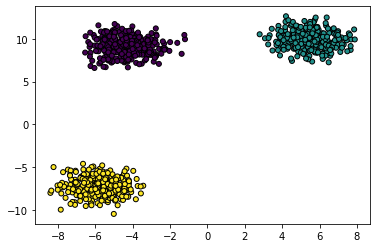

In [ ]:
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, s=25, edgecolor='k')
plt.show()

## The Elbow Method
This is probably the most well-known method for determining the optimal number of clusters. It is also a bit naive in its approach.

Calculate the **Within-Cluster-Sum of Squared Errors (WSS)** for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.

Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:
>The Squared Error for each point is the square of the distance of the point from its representation i.e. its predicted cluster center.

>The WSS score is the sum of these Squared Errors for all the points.

>Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

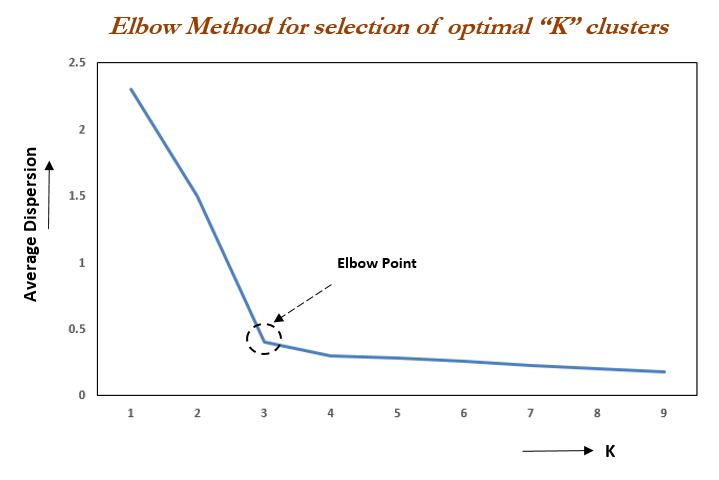

In [ ]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [ ]:
wss = calculate_WSS(X1, 10)

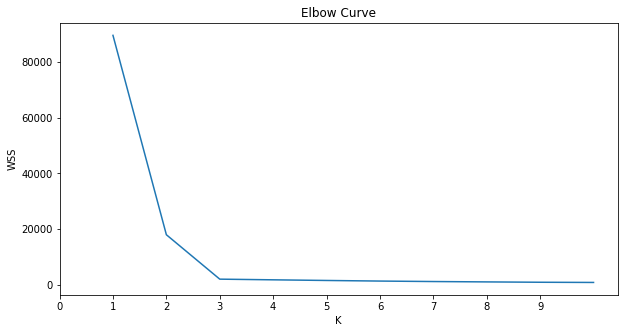

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1,len(wss)+1), wss)
plt.title("Elbow Curve")
plt.xlabel("K")
plt.ylabel("WSS")
plt.xticks(np.arange(10))
plt.show()